In [1]:
!pip install -U seaborn

    100% |████████████████████████████████| 286kB 6.3MB/s ta 0:00:01
    100% |████████████████████████████████| 11.5MB 1.6MB/s eta 0:00:01  2% |▉                               | 296kB 15.0MB/s eta 0:00:01    8% |██▋                             | 952kB 28.8MB/s eta 0:00:01    14% |████▌                           | 1.6MB 13.4MB/s eta 0:00:01    19% |██████▎                         | 2.3MB 13.5MB/s eta 0:00:01    28% |█████████▏                      | 3.3MB 6.8MB/s eta 0:00:02    32% |██████████▍                     | 3.8MB 7.4MB/s eta 0:00:02    35% |███████████▍                    | 4.1MB 7.9MB/s eta 0:00:01    40% |█████████████                   | 4.7MB 9.7MB/s eta 0:00:01    48% |███████████████▋                | 5.6MB 6.6MB/s eta 0:00:01    52% |████████████████▉               | 6.1MB 13.4MB/s eta 0:00:01    57% |██████████████████▌             | 6.7MB 12.8MB/s eta 0:00:01    69% |██████████████████████          | 8.0MB 14.9MB/s eta 0:00:01    74% |████████████████████████        |

In [3]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType, FloatType, StringType, DoubleType
import pyspark.sql.functions as F
from pyspark.sql.functions import count
from pyspark.sql import Window

from datetime import datetime
from statsmodels.stats.proportion import proportions_ztest

from time import time
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Wrangling Data") \
    .getOrCreate()

path = "mini_sparkify_event_data.json"
df = spark.read.json(path)

## Basic exploration and Cleaning

In [2]:
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [3]:
df.count(), len(df.columns)

(286500, 18)

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
# Dropping duplicated rows if any

df = df.distinct()

In [6]:
# Timespan in days

max_ts = df.agg({'ts': 'max'}).collect()[0][0]
min_ts = df.agg({'ts': 'min'}).collect()[0][0]
(max_ts - min_ts) / 86400000

63.04813657407407

### Missing values

In [41]:
missing = df.select([F.count(F.when((F.col(c) == '' ) | F.col(c).isNull() | 
                                     F.isnan(c), c)).alias(c) for c in df.columns])

missing.toPandas().T.rename(columns={0: 'Count'})\
.sort_values('Count', ascending=False).T.iloc[:, :13]

,artist,length,song,userAgent,registration,location,userId,lastName,gender,firstName,level,auth,page
Count,58392,58392,58392,8346,8346,8346,8346,8346,8346,8346,0,0,0


**length, song and artist** are missing when page is not "NextSong"

In [37]:
# same amount of pages that are not NextSong as missing values for those columns
df.filter(df.page != 'NextSong').count()

58392

In [11]:
df.filter(df.page != 'NextSong').select(['length', 'song', 'artist']).show(5)

+------+----+------+
|length|song|artist|
+------+----+------+
|  null|null|  null|
|  null|null|  null|
|  null|null|  null|
|  null|null|  null|
|  null|null|  null|
+------+----+------+
only showing top 5 rows



**registration, location, lastName, gender, firstName, userAgent** are missing when userId is an empty string

In [12]:
df.filter(df.userId == "").select(['registration', 'location', 'lastName', 'gender', 
                                   'firstName', 'userAgent']).show(5)

+------------+--------+--------+------+---------+---------+
|registration|location|lastName|gender|firstName|userAgent|
+------------+--------+--------+------+---------+---------+
|        null|    null|    null|  null|     null|     null|
|        null|    null|    null|  null|     null|     null|
|        null|    null|    null|  null|     null|     null|
|        null|    null|    null|  null|     null|     null|
|        null|    null|    null|  null|     null|     null|
+------------+--------+--------+------+---------+---------+
only showing top 5 rows



In [13]:
# Registration, as an example, has only empty strings as unique values for userId

df.where(F.col("registration").isNull()).select('userId').drop_duplicates().show()

+------+
|userId|
+------+
|      |
+------+



In [14]:
# same amount of empty strings for userId as missing values for the other columns
df.where(df.userId=="").count()

8346

**Pages that these userIds that are empty strings have visited**

In [15]:
allpages = df.select('page').dropDuplicates().collect()

visited = df.where(df.userId=="").select('page').dropDuplicates().collect()

In [16]:
visited = [p[0] for p in visited]
visited

['Home', 'About', 'Submit Registration', 'Login', 'Register', 'Help', 'Error']

In [17]:
unvisited = [p[0] for p in allpages if p not in visited]
unvisited

['Cancel',
 'Submit Downgrade',
 'Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'Cancellation Confirmation',
 'About',
 'Submit Registration',
 'Settings',
 'Login',
 'Register',
 'Add to Playlist',
 'Add Friend',
 'NextSong',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade']

**We will drop userIds that are empty strings** as they are users that didn't use the platform (probably because they could not register).

In [5]:
df = df.filter(df.userId != "")

In [19]:
df.count()

278154

### From timestamps to time columns

**create date column**

In [6]:
def get_date_string(ts): 
    return datetime.fromtimestamp(ts/1000.0).strftime('%Y-%m-%d %H:%M:%S')
    
get_date = F.udf(lambda ts: get_date_string(ts))

In [7]:
df = df.withColumn('date', get_date(df.ts))

**hour, day and weekday**

In [8]:
# functions

get_hour_udf = F.udf(lambda ts: datetime.fromtimestamp(ts/1000.0).hour)
get_day_udf = F.udf(lambda ts: datetime.fromtimestamp(ts/1000.0).day)
get_weekday_udf = F.udf(lambda ts: datetime.fromtimestamp(ts/1000.0).weekday())

In [9]:
# create columns

df = df.withColumn('hour', get_hour_udf(df.ts))
df = df.withColumn('day', get_day_udf(df.ts))
df = df.withColumn('weekday', get_weekday_udf(df.ts)) # monday is 0, sunday is 6

**days since registration**

In [10]:
# 86400000 miliseconds in 1 day
df = df.withColumn('days_since_registration', 
                   F.round((F.col('ts') - F.col('registration'))/86400000))

## Exploratory Data Analysis

In [11]:
def value_counts(df, column, figsize= 'default', n_show= 'max'):
    """ Prints a table and a barplot with Count and percentage 
    for each level in column 
    INPUTS:
        df: pyspark dataframe
        column - string: column name to count levels for 
        figsize - tuple: size of figure for barplot. If unspecified, default is used
        unless than more than 5 levels are plotted in which case (15,5) is used.
        n_show - int: number of column levels to plot. If unspecified, max 10 levels 
        are plotted """
    
    import pyspark.sql.functions as F

                
    # For columns related to userId, we need to get unique_users first
    if column in ['gender', 'has_churned', 'location']:
        
        # df = unique users
        df = df.select(['userId', column]).dropDuplicates()
        
    else:
        df = df
    
    
    ### Table
    col_df = df.groupBy(column).agg(
            (F.count(column)).alias('Count'),
            (F.round(F.count(column) / df.count() * 100, 2)).alias('percentage')) \
            .orderBy('Count', ascending=False)
    col_df.show()
    
    ### Barplot
    
    # n_show and figsize
    if n_show == 'max': 
        n_show = df.select(column).dropDuplicates().count()
        if n_show > 10: n_show = 10
        
    if figsize == 'default':
        if n_show > 5: figsize = (15,5)
        else: figsize = (6,4)
    
    # Plot
    fig, ax = plt.subplots(figsize= figsize)
    sns.barplot(x= column, y= 'percentage', data= col_df.toPandas()[:n_show], ax=ax);

**gender**
- Percentage of users in each classical gender

+------+-----+----------+
|gender|Count|percentage|
+------+-----+----------+
|     M|  121|     53.78|
|     F|  104|     46.22|
+------+-----+----------+



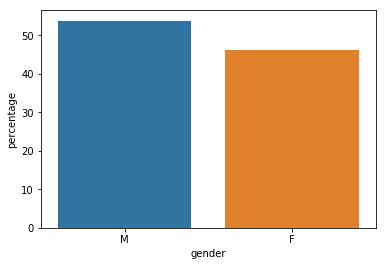

In [55]:
value_counts(df, 'gender')

**page**
- percentage of visits to each page

+--------------------+------+----------+
|                page| Count|percentage|
+--------------------+------+----------+
|            NextSong|228108|     82.01|
|           Thumbs Up| 12551|      4.51|
|                Home| 10082|      3.62|
|     Add to Playlist|  6526|      2.35|
|          Add Friend|  4277|      1.54|
|         Roll Advert|  3933|      1.41|
|              Logout|  3226|      1.16|
|         Thumbs Down|  2546|      0.92|
|           Downgrade|  2055|      0.74|
|            Settings|  1514|      0.54|
|                Help|  1454|      0.52|
|             Upgrade|   499|      0.18|
|               About|   495|      0.18|
|       Save Settings|   310|      0.11|
|               Error|   252|      0.09|
|      Submit Upgrade|   159|      0.06|
|    Submit Downgrade|    63|      0.02|
|              Cancel|    52|      0.02|
|Cancellation Conf...|    52|      0.02|
+--------------------+------+----------+



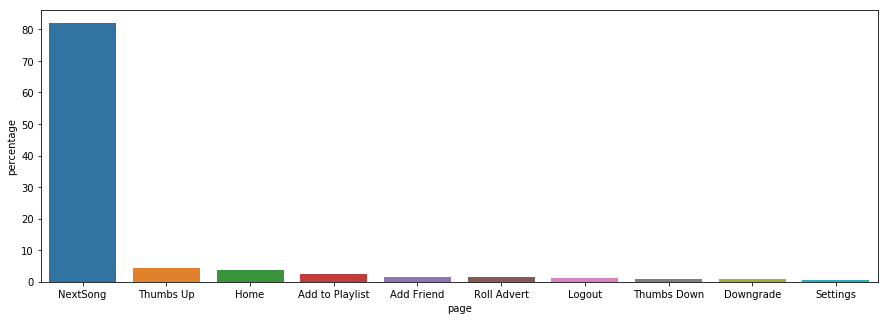

In [56]:
# Plot shows top 10
value_counts(df, 'page')

**auth**

+---------+------+----------+
|     auth| Count|percentage|
+---------+------+----------+
|Logged In|278102|     99.98|
|Cancelled|    52|      0.02|
+---------+------+----------+



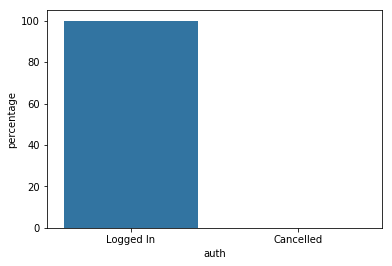

In [57]:
value_counts(df, 'auth')

**level**
- percentage of events experienced per users while in free/paid level

+-----+------+----------+
|level| Count|percentage|
+-----+------+----------+
| paid|222433|     79.97|
| free| 55721|     20.03|
+-----+------+----------+



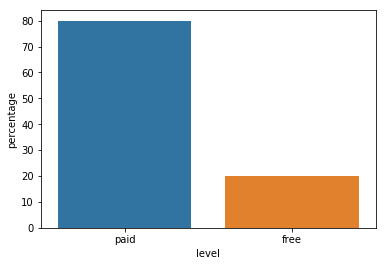

In [58]:
value_counts(df, 'level')

**from paid to free**

- Cuantas veces paso que un usuario cambie de "paid" a "free"? (incluye casos donde mismo usuario cambiaron mas de una vez)

In [59]:
# Flag "Submit Downgrade" page
flag_downgrade = F.udf(lambda p: int(p == 'Submit Downgrade'), IntegerType())
df = df.withColumn('downgraded', flag_downgrade('page'))

# Create "phase" column as a cumulative sum per user (ordered by time)
user_window = Window.partitionBy('userId').orderBy(F.desc('ts')) \
                    .rangeBetween(Window.unboundedPreceding, 0)
df = df.withColumn('phase', F.sum('downgraded').over(user_window))

Max phase value for each user es la cantidad de veces que ese usuario cambio de paid a free. La suma de todos esos maximos va a dar la cantida de veces total que sucedio que un usario cambie de paid a free.

In [60]:
phase_df = df.groupBy('userId').agg(F.max('phase').alias('max_phase'))

In [61]:
phase_df.show(3)

+------+---------+
|userId|max_phase|
+------+---------+
|100010|        0|
|200002|        0|
|   125|        0|
+------+---------+
only showing top 3 rows



In [62]:
phase_df.count() # checking it is the number of users

225

In [63]:
""" Amount of times that the event of a user downgrading service occurred"""

phase_df.agg(
    (F.sum('max_phase')).alias('result'),
    (F.round((F.sum('max_phase'))/ phase_df.count() * 100, 2)).alias('percentage')) \
    .show()

+------+----------+
|result|percentage|
+------+----------+
|    63|      28.0|
+------+----------+



- cuantos usuarios cambiaron al menos una vez de paid a free?

Since having a maximum value of 0 means you never downgraded the service, the users that downgraded the service at least once will have a maximum value of phase different from 0:

In [64]:
n_downgraded = phase_df.filter(phase_df.max_phase!=0).count()
percentage = round(n_downgraded / phase_df.count() * 100, 2)

In [65]:
print(n_downgraded, "users downgraded service at least once.", 
      percentage, "% of total users")

49 users downgraded service at least once. 21.78 % of total users


In [ ]:
del phase_df

**How many songs are played per hour, day and weekday?**

In [14]:
def plot_songs_per_timeunit(df, column):
    """
    Function to plot number of songs played per unit of time.
    
    df - dataframe with column to plot
    column - string - can be 'hour', 'day' or 'weekday'
    """
    
    songs_per_unit = df.filter(df.page == "NextSong").groupby(df[column]).count() \
                                                   .orderBy(df[column].cast("float"))
    
    # maxs and mins for plot
    max_n_songs = songs_per_unit.agg({"count": "max"}).collect()[0][0]
    min_n_songs = songs_per_unit.agg({"count": "min"}).collect()[0][0]
    
    max_value_column = songs_per_unit.agg(F.max(songs_per_unit[column].cast("int"))) \
                       .collect()[0][0] 
    min_value_column = songs_per_unit.agg(F.min(songs_per_unit[column].cast("int"))) \
                       .collect()[0][0]
    
    # plot
    plt.ylim((min_n_songs -500), (max_n_songs +500))
    sns.barplot(x= column, y= 'count', data= songs_per_unit.toPandas(),
               order= [str(n) for n in np.arange(min_value_column, max_value_column+1)]);

**Songs per hour**

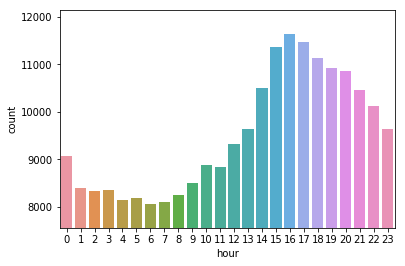

In [15]:
plot_songs_per_timeunit(df, 'hour')

**Songs per day**

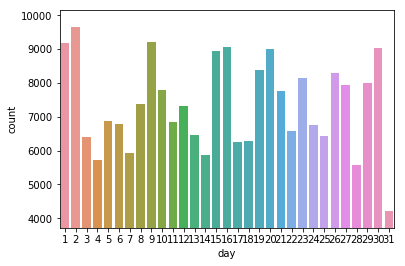

In [16]:
plot_songs_per_timeunit(df, 'day')

**Songs per day of the week**

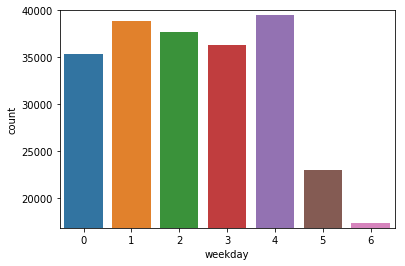

In [17]:
# 0 is monday and 6 is sunday

plot_songs_per_timeunit(df, 'weekday')

## Churn Definition and Analysis of differences between groups

Let's now define churn and explore the diffencess between users who chuned (churned_users) and users who stayed (stayed_users).

In [18]:
# Churn
user_window = Window.partitionBy('userId').orderBy(F.desc('ts')) \
                .rangeBetween(Window.unboundedPreceding, 0)

flag_churn = F.udf(lambda p: int(p == "Cancellation Confirmation"), IntegerType())
df = df.withColumn('is_churning', flag_churn(df.page))
df = df.withColumn('has_churned', F.max('is_churning').over(user_window))

- How many churned users do we have?

+-----------+-----+----------+
|has_churned|Count|percentage|
+-----------+-----+----------+
|          0|  173|     76.89|
|          1|   52|     23.11|
+-----------+-----+----------+



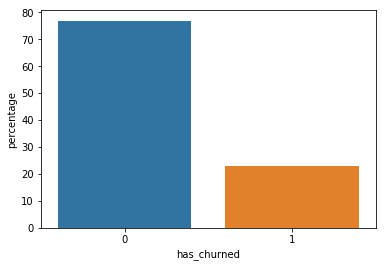

In [19]:
value_counts(df, 'has_churned')

In [22]:
def load_and_clean(path= "mini_sparkify_event_data.json"):
    """ Loads and cleans dataframe for EDA and further feature engineering."""
    
    # Loading
    spark = SparkSession \
        .builder \
        .appName("Wrangling Data") \
        .getOrCreate()

    df = spark.read.json(path)
    
    # Dropping missing users
    df = df.filter(df.userId != "")
    
    # Cleaning userId 155
    min_ts_155 = df.filter(df.userId=='155').agg({'ts': 'min'}).collect()[0][0]
    df = df.withColumn('registration', F.when(F.col('userId') == '155', min_ts_155)\
                        .otherwise(df.registration))

    # Get date
    df = df.withColumn("date", F.to_date(F.from_unixtime(F.col('ts')/F.lit(1000))))

    # Time columns
    get_hour_udf = F.udf(lambda ts: datetime.fromtimestamp(ts/1000.0).hour)
    get_day_udf = F.udf(lambda ts: datetime.fromtimestamp(ts/1000.0).day)
    get_weekday_udf = F.udf(lambda ts: datetime.fromtimestamp(ts/1000.0).weekday())

    df = df.withColumn('hour', get_hour_udf(df.ts))
    df = df.withColumn('day', get_day_udf(df.ts))
    df = df.withColumn('weekday', get_weekday_udf(df.ts)) # monday is 0, sunday is 6

    # Days since registration
    df = df.withColumn('registration_date', F.to_date(
        F.from_unixtime(F.col('registration')/F.lit(1000))))
    df = df.withColumn('days_since_registration', F.datediff(
        F.col('date'), F.col('registration_date')))

    # Churn
    user_window = Window.partitionBy('userId').orderBy(F.desc('ts')) \
                    .rangeBetween(Window.unboundedPreceding, 0)

    flag_churn = F.udf(lambda p: int(p == "Cancellation Confirmation"), IntegerType())
    df = df.withColumn('is_churning', flag_churn(df.page))
    df = df.withColumn('has_churned', F.max('is_churning').over(user_window))

    return df

In [23]:
df = load_and_clean()

### **level** 

- From all the users who were paid users at some point, what percentage of each group downgraded the service at least once? If there is a difference, it might be something to flag in order to predict churning

In [24]:
once_paid_users = [u[0] for u in df.filter(df.level=='paid').select('userId') \
                   .dropDuplicates().collect()]

In [25]:
len(once_paid_users)

165

In [26]:
# Max_phase for each user is the amout of times that the user downgraded the service
phase_df = df.filter(df.userId.isin(once_paid_users)) \
             .groupBy(['userId', 'has_churned']).agg(F.max('phase').alias('max_phase'))

phase_df.show(3)

AnalysisException: "cannot resolve '`phase`' given input columns: [hour, days_since_registration, weekday, page, ts, location, song, lastName, firstName, sessionId, registration, date, length, level, method, itemInSession, day, status, registration_date, auth, userAgent, artist, is_churning, userId, gender, has_churned];;\n'Aggregate [userId#1909, has_churned#2138], [userId#1909, has_churned#2138, max('phase) AS max_phase#2195]\n+- Filter userId#1909 IN (200002,51,124,54,15,155,132,100014,101,11,138,300017,69,29,42,73,87,3,30,113,59,139,28,300018,300012,85,16,35,52,300008,71,98,300013,99,100008,100025,300006,300002,96,300007,100,18,70,61,75,131,140,17,126,26,100007,120,200007,46,300004,147,300001,300015,77,89,136,6,118,300019,200014,100009,300011,60,104,100004,200003,100015,19,300023,300024,41,128,23,200024,55,200008,111,100016,95,93,38,103,40,200005,25,200009,44,115,82,200023,53,92,122,108,86,200017,58,300014,81,33,114,100012,200025,153,200020,141,97,106,67,79,300025,9,24,32,152,88,105,20,200011,100023,142,100013,56,127,36,300009,10,37,300022,49,300021,200004,300005,300020,65,121,4,39,62,12,83,109,13,200019,14,21,66,91,74,137,300016,151,129,2,100002,100018,145,50,45,200021)\n   +- Project [artist#1892, auth#1893, firstName#1894, gender#1895, itemInSession#1896L, lastName#1897, length#1898, level#1899, location#1900, method#1901, page#1902, registration#1953L, sessionId#1904L, song#1905, status#1906L, ts#1907L, userAgent#1908, userId#1909, date#1972, hour#1993, day#2015, weekday#2038, registration_date#2061, days_since_registration#2085, ... 2 more fields]\n      +- Project [artist#1892, auth#1893, firstName#1894, gender#1895, itemInSession#1896L, lastName#1897, length#1898, level#1899, location#1900, method#1901, page#1902, registration#1953L, sessionId#1904L, song#1905, status#1906L, ts#1907L, userAgent#1908, userId#1909, date#1972, hour#1993, day#2015, weekday#2038, registration_date#2061, days_since_registration#2085, ... 3 more fields]\n         +- Window [max(is_churning#2111) windowspecdefinition(userId#1909, ts#1907L DESC NULLS LAST, specifiedwindowframe(RangeFrame, unboundedpreceding$(), currentrow$())) AS has_churned#2138], [userId#1909], [ts#1907L DESC NULLS LAST]\n            +- Project [artist#1892, auth#1893, firstName#1894, gender#1895, itemInSession#1896L, lastName#1897, length#1898, level#1899, location#1900, method#1901, page#1902, registration#1953L, sessionId#1904L, song#1905, status#1906L, ts#1907L, userAgent#1908, userId#1909, date#1972, hour#1993, day#2015, weekday#2038, registration_date#2061, days_since_registration#2085, is_churning#2111]\n               +- Project [artist#1892, auth#1893, firstName#1894, gender#1895, itemInSession#1896L, lastName#1897, length#1898, level#1899, location#1900, method#1901, page#1902, registration#1953L, sessionId#1904L, song#1905, status#1906L, ts#1907L, userAgent#1908, userId#1909, date#1972, hour#1993, day#2015, weekday#2038, registration_date#2061, days_since_registration#2085, <lambda>(page#1902) AS is_churning#2111]\n                  +- Project [artist#1892, auth#1893, firstName#1894, gender#1895, itemInSession#1896L, lastName#1897, length#1898, level#1899, location#1900, method#1901, page#1902, registration#1953L, sessionId#1904L, song#1905, status#1906L, ts#1907L, userAgent#1908, userId#1909, date#1972, hour#1993, day#2015, weekday#2038, registration_date#2061, datediff(date#1972, registration_date#2061) AS days_since_registration#2085]\n                     +- Project [artist#1892, auth#1893, firstName#1894, gender#1895, itemInSession#1896L, lastName#1897, length#1898, level#1899, location#1900, method#1901, page#1902, registration#1953L, sessionId#1904L, song#1905, status#1906L, ts#1907L, userAgent#1908, userId#1909, date#1972, hour#1993, day#2015, weekday#2038, to_date(from_unixtime(('registration / 1000), yyyy-MM-dd HH:mm:ss, None), None) AS registration_date#2061]\n                        +- Project [artist#1892, auth#1893, firstName#1894, gender#1895, itemInSession#1896L, lastName#1897, length#1898, level#1899, location#1900, method#1901, page#1902, registration#1953L, sessionId#1904L, song#1905, status#1906L, ts#1907L, userAgent#1908, userId#1909, date#1972, hour#1993, day#2015, <lambda>(ts#1907L) AS weekday#2038]\n                           +- Project [artist#1892, auth#1893, firstName#1894, gender#1895, itemInSession#1896L, lastName#1897, length#1898, level#1899, location#1900, method#1901, page#1902, registration#1953L, sessionId#1904L, song#1905, status#1906L, ts#1907L, userAgent#1908, userId#1909, date#1972, hour#1993, <lambda>(ts#1907L) AS day#2015]\n                              +- Project [artist#1892, auth#1893, firstName#1894, gender#1895, itemInSession#1896L, lastName#1897, length#1898, level#1899, location#1900, method#1901, page#1902, registration#1953L, sessionId#1904L, song#1905, status#1906L, ts#1907L, userAgent#1908, userId#1909, date#1972, <lambda>(ts#1907L) AS hour#1993]\n                                 +- Project [artist#1892, auth#1893, firstName#1894, gender#1895, itemInSession#1896L, lastName#1897, length#1898, level#1899, location#1900, method#1901, page#1902, registration#1953L, sessionId#1904L, song#1905, status#1906L, ts#1907L, userAgent#1908, userId#1909, to_date(from_unixtime(('ts / 1000), yyyy-MM-dd HH:mm:ss, None), None) AS date#1972]\n                                    +- Project [artist#1892, auth#1893, firstName#1894, gender#1895, itemInSession#1896L, lastName#1897, length#1898, level#1899, location#1900, method#1901, page#1902, CASE WHEN (userId#1909 = 155) THEN 1541174185000 ELSE registration#1903L END AS registration#1953L, sessionId#1904L, song#1905, status#1906L, ts#1907L, userAgent#1908, userId#1909]\n                                       +- Filter NOT (userId#1909 = )\n                                          +- Relation[artist#1892,auth#1893,firstName#1894,gender#1895,itemInSession#1896L,lastName#1897,length#1898,level#1899,location#1900,method#1901,page#1902,registration#1903L,sessionId#1904L,song#1905,status#1906L,ts#1907L,userAgent#1908,userId#1909] json\n"

In [ ]:
phase_df.count() # checking

In [ ]:
print("Churning rate for all once_paid_users:")
phase_df.agg({'has_churned': 'avg'}).show()

Since having a maximum value of 0 means you never downgraded the service, the users that downgraded the service at least once will have a maximum value of phase different from 0.

In [ ]:
print("Churning rate for once_paid_users that did NOT downgrade service:")
phase_df.filter(phase_df.max_phase==0).agg({'has_churned': 'avg'}).show()

In [ ]:
print("Churning rate for once_paid_users that DID downgrade service:")
phase_df.filter(phase_df.max_phase!=0).agg({'has_churned': 'avg'}).show()

Apparently, paid users who didn't downgrade service are more likely to churn that those who did downgraded service. This is counterintuitive at first glance, but since there's a difference, flagging service downgrade might help the model to predict churning.

- What about users who were once_free_users?

In [ ]:
once_free_users = [u[0] for u in df.filter(df.level=='free').select('userId') \
                   .dropDuplicates().collect()]

In [ ]:
# Max_phase for each user is the amout of times that the user downgraded the service
free_phase_df = df.filter(df.userId.isin(once_free_users)) \
               .groupBy(['userId', 'has_churned']).agg(F.max('phase').alias('max_phase'))

In [ ]:
print("Churning rate for all once_free_users:")
free_phase_df.agg({'has_churned': 'avg'}).show()

In [ ]:
print("Churning rate for once_free_users that did NOT downgrade service:")
free_phase_df.filter(free_phase_df.max_phase==0).agg({'has_churned': 'avg'}).show()

In [ ]:
print("Churning rate for once_free_users that DID downgrade service:")
free_phase_df.filter(free_phase_df.max_phase!=0).agg({'has_churned': 'avg'}).show()

The difference is in the same direction.

### Total general Activity

In [27]:
dfr = df.filter((df.page!= 'Cancel') & (df.page != 'Cancellation Confirmation'))

page_counts = dfr.groupby(['userId', 'page']).agg((F.count('page')).alias('Count')) \
                 .groupby('userId').pivot('page').sum('Count').fillna(0)

In [28]:
gral_activity = page_counts.withColumn(
    'gral_activity', np.sum([F.col(p) for p in page_counts.columns[1:]]))

In [29]:
cols_to_drop = gral_activity.columns[1:-1]
gral_activity_red = gral_activity.drop(*cols_to_drop)

churn_status = dfr.select(['userId', 'has_churned']).dropDuplicates()
joined = gral_activity_red.join(churn_status, on='userId')

avg_gral_activity = joined.groupby('has_churned').agg({'gral_activity':'avg'})

In [30]:
avg_gral_activity.show()

+-----------+------------------+
|has_churned|avg(gral_activity)|
+-----------+------------------+
|          1| 860.7692307692307|
|          0|1348.4971098265896|
+-----------+------------------+



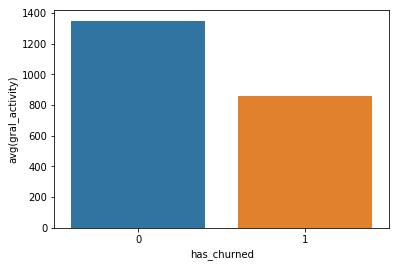

In [31]:
sns.barplot(x= "has_churned", y= "avg(gral_activity)", data= avg_gral_activity.toPandas());

It seems that churned_users have less activity in general, but let's explore if there's also a difference in the total number of days in the platform in average for each group.

### Days in platform
We will consider total days in platform, meaning all days since registration until last interaction (including non-active days).

In [32]:
total_days = df.groupby('userId', 'has_churned')\
                .agg(F.max('days_since_registration').alias('total_days'))

AttributeError: module 'seaborn' has no attribute 'histplot'

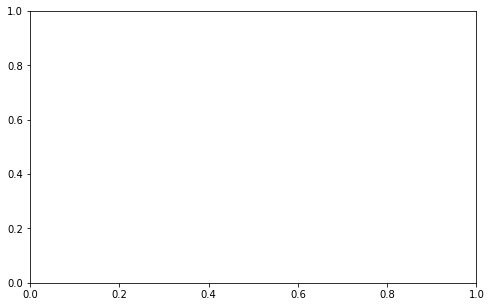

In [33]:
# We need to first upgrade Seaborn with the first cell in this notebook
# and restart kernel, before being able to run this cell.

total_days_pd = total_days.toPandas()
fig, ax = plt.subplots(figsize= (8,5))
sns.histplot(total_days_pd, x= 'total_days', alpha=.5, hue='has_churned', kde = True);

In [34]:
total_days.groupby('has_churned').agg({'total_days':'avg'}).show()

+-----------+-----------------+
|has_churned|  avg(total_days)|
+-----------+-----------------+
|          1|57.36538461538461|
|          0|86.57803468208093|
+-----------+-----------------+



It looks like churned_users were in the platform less days in average than stayed_users as well. Therefore, we will check if churned_users are actually less active in average than stayed_users, weighting total activity by the number of days in the platform.

### General Activity weighted by days in platform

In [35]:
def weight_by_days(grouped_df):
    """ INPUT: df - dataframe with the average of any column grouped by has_churned.
        OUTPUT: same averages weighted by total days in platform per group. """
    
    # average total days per group
    avg_days= df.groupby(['userId', 'has_churned']) \
                .agg(F.max('days_since_registration').alias('total_days')) \
                .groupby('has_churned').agg({'total_days':'avg'})
    
    temp = grouped_df.join(avg_days, on='has_churned')
    
    for c in temp.columns[1:]:
        if c != 'avg(total_days)':
            temp = temp.withColumn(c, F.col(c) / F.col('avg(total_days)'))

    daily_df = temp.drop('avg(total_days)')

    return daily_df

In [36]:
daily_activity = weight_by_days(avg_gral_activity)

In [37]:
daily_activity.show()

+-----------+------------------+
|has_churned|avg(gral_activity)|
+-----------+------------------+
|          1|15.005028494803888|
|          0|15.575510749098678|
+-----------+------------------+



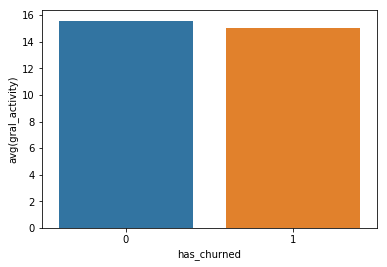

In [38]:
sns.barplot(x= "has_churned", y= "avg(gral_activity)", data= daily_activity.toPandas());

Once it's weighted by the average number of days in platform, there's no difference in general activity between groups. Hence, from now on we will explore their  differences in relation to daily averages, rather than totals.

### Proportion of users per page
- Weighted by days in platform

In [39]:
# page counts per user, plus has_churned
page_counts_churn = page_counts.join(churn_status, on='userId')

In [40]:
# avg of counts per group
page_names = page_counts_churn.columns[1:]
avg_per_page = page_counts_churn.groupby('has_churned')\
                                .agg({p:'avg' for p in page_names})

In [41]:
# weight by total days in platform
daily_counts = weight_by_days(avg_per_page)

In [42]:
def prep_to_plot(weighted_df):
    """ Transforms df to plot, and orders features by descending values """
    
    melt_df = weighted_df.toPandas().melt(id_vars=["has_churned"], 
                                             var_name="page", value_name="value")
    
    # order pages by descending value
    order_pages = melt_df.sort_values(by=['value', 'page'], ascending=False)\
    .page.unique().tolist()
    
    # sort according to order_pages
    sort_dict = {p:i for i,p in enumerate(order_pages)}
    sorted_data = melt_df.iloc[melt_df['page'].map(sort_dict).sort_values().index]
    
    return sorted_data, order_pages

In [43]:
sorted_data, order_pages = prep_to_plot(daily_counts)

In [44]:
sorted_data.head(6)

,has_churned,page,value
13,0,avg(NextSong),12.799706
12,1,avg(NextSong),12.200469
24,1,avg(Thumbs Up),0.623198
25,0,avg(Thumbs Up),0.713847
23,0,avg(Home),0.561490
22,1,avg(Home),0.560510


In [45]:
def plot(sorted_data, order_pages, n='all'):
    """ Plots sorted data and order pages that you get from prep_to_plot(weighted_df).
    n - number of columns to plot. By default, all are plotted """
    
    if n=='all': 
        n = len(order_pages)
    
    if n > 3: figsize= (15,3)
    else: figsize= (8,5)
        
    fig, ax = plt.subplots(figsize= figsize)
    sns.barplot(x= "page", y= "value", hue= "has_churned", 
            data= sorted_data[:2*n], order= order_pages[:n]);

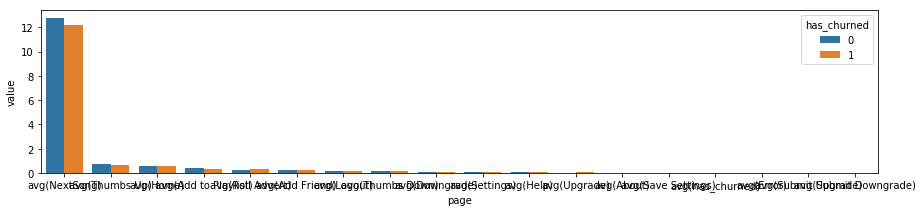

In [46]:
# plot top 6
plot(sorted_data, order_pages, n='all')

It doesn't seem to be much difference considering pages individually. Let's try grouping them by the type of interaction they imply.

### Proportion of users per Type of Interaction

We will explore the average of positive, neutral and negative interactions (weighted by days in platform). This is how "type of in interaction" will be defined:
- **positive**: 'Thumbs Up', 'Add Friend' and 'Add to Playlist'
- **neutral**: 'About', 'Home' and 'Settings'
- **negative**: 'Thumbs Down', 'Error', 'Roll Advert'

In [47]:
type_counts = page_counts.withColumn(
    'positive_interact', F.col('Add Friend')+F.col('Add to Playlist')+F.col('Thumbs Up'))
type_counts = type_counts.withColumn(
    'negative_interact', F.col('Thumbs Down')+F.col('Error')+F.col('Roll Advert'))
type_counts = type_counts.withColumn(
    'neutral_interact', F.col('About')+F.col('Home')+F.col('Settings'))

In [48]:
type_counts = type_counts.drop(*type_counts.columns[1:-3])

In [49]:
type_names = type_counts.columns[1:]

In [50]:
avg_per_type = type_counts.join(churn_status, on='userId').groupby('has_churned') \
                                         .agg({t:'avg' for t in type_names})

In [51]:
daily_types = weight_by_days(avg_per_type)

In [52]:
sorted_data, order_pages = prep_to_plot(daily_types)

In [53]:
sorted_data.head()

,has_churned,page,value
2,1,avg(positive_interact),1.184378
3,0,avg(positive_interact),1.323341
0,1,avg(neutral_interact),0.669796
1,0,avg(neutral_interact),0.673855
4,1,avg(negative_interact),0.501173


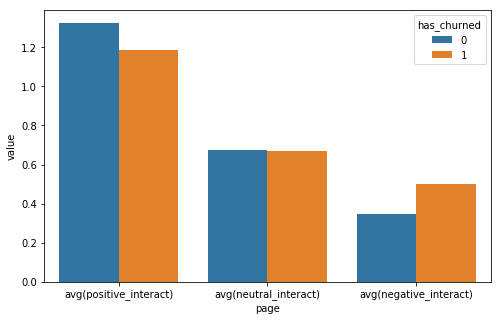

In [54]:
plot(sorted_data, order_pages)

### Average of downgrades and upgrades per group

The number of downgrades is the amount of times a user changed from paid to free tier, which in some cases is more than one. The opposite happens for number of upgrades. In this case we will consider users who were paid users since the beginning as having upgraded at least once, since there's no other way to become a paid user than upgrading the service.

As with the other features, we will weight the averages by total days in platform.

**n_downgraded**

In [55]:
flag_downgrade = F.udf(lambda p: int(p == 'Submit Downgrade'), IntegerType())
downgrad_df = df.withColumn('is_downgrading', flag_downgrade('page'))

user_window = Window.partitionBy('userId').orderBy(F.desc('ts')) \
                    .rangeBetween(Window.unboundedPreceding, 0)

# Create "down_phase" column as a cumulative sum per user (ordered by time)
downgrad_df = downgrad_df.withColumn('down_phase', F.sum('is_downgrading') \
                                     .over(user_window))

# Max down_phase is the number of times that a user changed from paid to free level
downgrad_df = downgrad_df.groupBy(['userId', 'has_churned']).agg(F.max('down_phase') \
                                                .alias('n_downgraded'))

**n_upgraded**

1) Create first_level column to recognize those who started as paid users

In [56]:
# obs: row_number() returns a sequential number starting at 1 within a window partition.
# in this case, the first row corresponds to min(ts) (bc of how partition was made)
# The other values are Null

w = Window().partitionBy("userId").orderBy(F.asc("ts")) 

upgrad_df = df.withColumn("first_level", F.when(F.row_number().over(w) == 1, 
                                                 F.col('level')))

2) Flag upgrade considering page and first_level

In [57]:
flag_upgrade = F.udf(lambda p, fl: int((p== 'Submit Upgrade') | (fl== 'paid')), 
                     IntegerType())

upgrad_df = upgrad_df.withColumn('is_upgrading', 
                                 flag_upgrade(upgrad_df.page, upgrad_df.first_level))

3) Create "up_phase" column as a cumulative sum per user (ordered by time)

In [58]:
upgrad_df = upgrad_df.withColumn('up_phase', F.sum('is_upgrading').over(user_window))

# Max up_phase is the number of times that a user changed from free to paid level
upgrad_df = upgrad_df.groupBy('userId').agg(F.max('up_phase').alias('n_upgraded'))

**join and get daily averages**

In [59]:
avg_grades = downgrad_df.join(upgrad_df, on='userId').groupby('has_churned') \
                                         .agg({'n_downgraded':'avg', 'n_upgraded':'avg'})

In [60]:
avg_grades.show()

+-----------+-------------------+------------------+
|has_churned|  avg(n_downgraded)|   avg(n_upgraded)|
+-----------+-------------------+------------------+
|          1|0.17307692307692307|0.7692307692307693|
|          0|0.31213872832369943|0.9653179190751445|
+-----------+-------------------+------------------+



In [61]:
daily_grades = weight_by_days(avg_grades)

In [62]:
sorted_data, order_pages = prep_to_plot(daily_grades)

In [63]:
sorted_data.head()

,has_churned,page,value
2,1,avg(n_upgraded),0.013409
3,0,avg(n_upgraded),0.011150
0,1,avg(n_downgraded),0.003017
1,0,avg(n_downgraded),0.003605


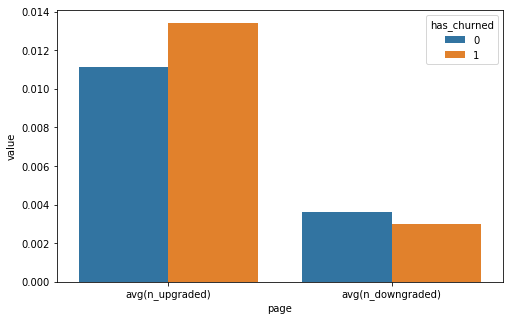

In [64]:
plot(sorted_data, order_pages)

Interestingly, there seems to be a small difference between the groups, in a counter-intuitive direction. Apparently, churned_users are slightly more likely to upgrade their service, and stayed_users to downgrade it.

## Feature Engineering

### **Features**

- **gender**: male or female
- **prop_activity**: proportion of active days over total days in platform (from registration to last interaction)
- **once_paid**: 1 if the user has been a paid user at least once
- **once_free**: 1 if the user has been a free user at least once
- **avg_downgrad**: number of downgrades weighted by active days
- **avg_upgrad**: number of uprades weighted by active days
- **avg(positive)**: daily average of positive interactions                                         
- **avg(negative)**: daily average of negative interactions
- **avg(NextSong)**: daily average of songs listened to
- **avg_sessions**: daily average of distinct sessions
- **avg_items_session**: average of items per session
- **avg_length_session**: daily average length per session in days
- **avg_session_gap**: average gap between sessions in days

--------------------------------------------------------------------------------
**obs:** daily average considers only days in which the user was active in the platform (instead of the total amount of days the user has been registered)

### gender

In [65]:
gender_df = df.select(['userId', 'gender']).dropDuplicates()

In [66]:
# encode
gender_df = gender_df.withColumn("gender", F.when(df["gender"] == 'F', 1).otherwise(0))

In [167]:
gender_df.count()

225

### prop_activity
**Proportion of active days over total days**

In [67]:
total_days = df.groupby('userId')\
               .agg(F.max('days_since_registration').alias('total_days'))
active_days = df.groupby('userId').agg(F.countDistinct('date').alias('active_days'))

In [68]:
avg_activity = total_days.join(active_days, on='userId').withColumn('prop_activity',
                                         F.col('active_days')/F.col('total_days'))\
                                         .drop(*['active_days', 'total_days'])

In [170]:
avg_activity.count()

225

### once_paid and once_free

**Flags users that have ever been paid or free users respectively**

In [69]:
# flag once_paid and once_free
flag_paid = F.udf(lambda l: int(l == 'paid'), IntegerType())
flag_free = F.udf(lambda l: int(l == 'free'), IntegerType())

# is_paid is 1 whenever the user was in level == paid (same logic for is_free)
df = df.withColumn('is_paid', flag_paid(df.level))
df = df.withColumn('is_free', flag_free(df.level))

In [70]:
once_level = df.groupby('userId').agg(
    F.max('is_paid').alias('once_paid'),
    F.max('is_free').alias('once_free'))

In [173]:
once_level.count()

225

### avg_downgrad and avg_upgrad
**number of downgrades and upgrades respectively, weighted by active days**

In [71]:
### avg_downgrad
user_window = Window.partitionBy('userId').orderBy(F.desc('ts')) \
                    .rangeBetween(Window.unboundedPreceding, 0)

flag_downgrade = F.udf(lambda p: int(p == 'Submit Downgrade'), IntegerType())
downgrad_df = df.withColumn('is_downgrading', flag_downgrade('page'))
downgrad_df = downgrad_df.withColumn('down_phase', F.sum('is_downgrading') \
                                     .over(user_window))
downgrad_df = downgrad_df.groupBy('userId').agg(F.max('down_phase') \
                                                .alias('n_downgraded'))   

active_days = df.groupby('userId').agg(F.countDistinct('date')\
                                    .alias('active_days'))
avg_downgrad = downgrad_df.join(active_days, on='userId').withColumn(
                        'avg_downgrad', F.col('n_downgraded')/F.col('active_days'))\
                        .drop(*['n_downgraded', 'active_days'])

In [72]:
### avg_upgrad
w = Window().partitionBy("userId").orderBy(F.asc("ts")) 
upgrad_df = df.withColumn("first_level", F.when(F.row_number().over(w) == 1, 
                                                F.col('level')))
flag_upgrade = F.udf(lambda p, fl: int((p== 'Submit Upgrade') | (fl== 'paid')), 
                 IntegerType())
upgrad_df = upgrad_df.withColumn('is_upgrading', 
                                 flag_upgrade(upgrad_df.page, upgrad_df.first_level))

upgrad_df = upgrad_df.withColumn('up_phase', F.sum('is_upgrading').over(user_window))
upgrad_df = upgrad_df.groupBy('userId').agg(F.max('up_phase').alias('n_upgraded'))

avg_upgrad = upgrad_df.join(active_days, on='userId').withColumn(
                            'avg_upgrad', F.col('n_upgraded')/F.col('active_days'))\
                            .drop(*['n_upgraded', 'active_days'])

In [176]:
avg_downgrad.count(), avg_upgrad.count()

(225, 225)

### avg_positive and avg_negative
**daily average of positive and negative interactions respectively** 

In [73]:
### avg(positive) and avg(negative)
dfr = df.filter((df.page!= 'Cancel') & (df.page != 'Cancellation Confirmation'))
page_counts = dfr.groupby(['userId', 'page']).agg((F.count('page')).alias('Count')) \
                 .groupby('userId').pivot('page').sum('Count').fillna(0)

type_counts = page_counts.withColumn('positive_interact', 
                    F.col('Add Friend')+ F.col('Add to Playlist')+ F.col('Thumbs Up'))
type_counts = type_counts.withColumn('negative_interact', 
                    F.col('Thumbs Down')+ F.col('Error')+ F.col('Roll Advert'))

cols_to_drop = type_counts.columns[1:-2]
type_counts_red = type_counts.drop(*cols_to_drop)

joined = type_counts_red.join(active_days, on='userId')
avg_types = joined.withColumn('avg_positive', 
                              F.col('positive_interact')/F.col('active_days')) \
                              .drop('positive_interact')
avg_types = avg_types.withColumn('avg_negative', 
                                 F.col('negative_interact')/F.col('active_days')) \
                                 .drop(*['negative_interact', 'active_days'])

In [178]:
avg_types.count()

225

### avg_songs
**daily average of songs listened to**

In [74]:
songs_count = page_counts.select('userId', 'NextSong')

In [75]:
joined = songs_count.join(active_days, on='userId')
avg_songs = joined.withColumn('avg_songs', 
                              F.col('NextSong')/F.col('active_days')) \
                              .drop('active_days')

In [181]:
avg_songs.count()

225

### avg_sessions
**daily average of distinct sessions**

In [76]:
avg_sessions = df.groupby('userId','date').agg(F.countDistinct('sessionId') \
                                               .alias('sessions_per_day')) \
                 .groupBy('userId').agg(F.avg('sessions_per_day').alias('avg_sessions'))

In [183]:
avg_sessions.count()

225

### avg_items_session
**average of items per session**

In [77]:
avg_items = df.groupby(['userId', 'sessionId']).agg(F.max('itemInSession') \
                                                   .alias('n_items_session')) \
              .groupby('userId').agg(F.avg('n_items_session').alias('avg_items_session'))

In [185]:
avg_items.count()

225

### avg_length_session
**daily average length per session in days**

In [78]:
avg_session_length = dfr.groupby(['userId','date','sessionId']).agg(
                                 F.min('ts').alias('start'), F.max('ts').alias('end')) \
                        .withColumn('session_length', (F.col('end') - F.col('start'))) \
                        .groupby(['userId', 'date']).agg(F.avg('session_length')\
                                                          .alias('avg_within_day')) \
                        .groupby('userId').agg((F.avg('avg_within_day')/ 86400000)
                                                 .alias('avg_length_session'))

In [187]:
avg_session_length.count()

225

### avg_session_gap
**average gap between sessions in days**

In [79]:
# mark the beggining and ending of a session
session_marks_df = df.groupby('userId','sessionId').agg(F.min('ts').alias('begin_ts'),
                                                        F.max('ts').alias('end_ts'))

# create window partitioning by users
w = Window.partitionBy('userID').orderBy('begin_ts')

# create column flagging the ts of the last ending of a session (previous session) 
# obs: lag() by default returns the previous row at any given point in the partition
session_marks_df = session_marks_df.withColumn('last_end', F.lag(F.col('end_ts')).over(w))

# create gap column: new session ts (begin_ts) - previous session ts ('last_end')
# obs: datediff(end, start) returns the number of days from start to end
session_marks_df = session_marks_df.withColumn('session_gap', 
                                    (F.col('begin_ts') - F.col('last_end')))

# get average of gaps
avg_session_gap = session_marks_df.groupby('userId').agg((F.avg('session_gap') /86400000) \
                                                           .alias('avg_session_gap'))

In [189]:
avg_session_gap.count()

225

### Joining all features together

In [80]:
### joining all together
all_features = gender_df \
                        .join(avg_activity, on='userId')\
                        .join(once_level, on='userId')\
                        .join(avg_downgrad, on='userId')\
                        .join(avg_upgrad, on='userId')\
                        .join(avg_types, on='userId')\
                        .join(avg_songs, on='userId')\
                        .join(avg_sessions, on='userId')\
                        .join(avg_items, on='userId')\
                        .join(avg_session_length, on='userId')\
                        .join(avg_session_gap, on='userId')

### Checking correlations

In [23]:
feats_pd = all_features.toPandas()

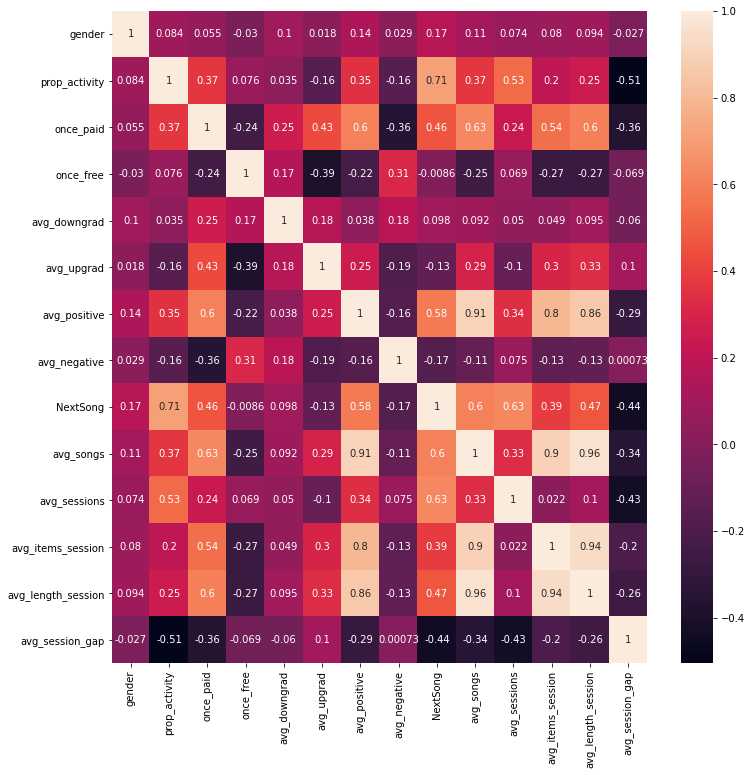

In [191]:
plt.figure(figsize= [12, 12])
sns.heatmap(feats_pd.corr(), annot=True);

Let's assess **multicollinearity** now using the **Variance Inflation Factor (VIF)**

Correlation matrix and scatter plots only show the bivariate relationship between the independent variables. VIF can show the correlation of a variable with a group of other variables.

In [24]:
# we need to drop nan values and userId
feats_pd.dropna(inplace=True)
feats_pd = feats_pd.drop('userId', axis=1)

In [193]:
feats_pd.columns

Index(['gender', 'prop_activity', 'once_paid', 'once_free', 'avg_downgrad',
       'avg_upgrad', 'avg_positive', 'avg_negative', 'NextSong', 'avg_songs',
       'avg_sessions', 'avg_items_session', 'avg_length_session',
       'avg_session_gap'],
      dtype='object')

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X):
    """Function to calculate variance inflation factor (VIF) 
    given a dataframe with numerical variables"""

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [26]:
VIF_df = calculate_vif(feats_pd)
VIF_df.sort_values(by='VIF', ascending=False)[:5]

,variables,VIF
9,avg_songs,209.895451
12,avg_length_session,145.437541
11,avg_items_session,56.796456
6,avg_positive,38.220928
10,avg_sessions,34.598014


We will drop 'avg_songs' and 'avg_length_session' since they are the ones with the highest multicollinearity.

In [27]:
all_features = all_features.drop('avg_songs', 'avg_length_session')

### Inspecting new missing values

In [29]:
missing = all_features.select([F.count(F.when(
    (F.col(c) == '')  | F.col(c).isNull() | F.isnan(c), c)) \
    .alias(c) for c in all_features.columns])

In [198]:
missing.collect()

[Row(userId=0, gender=0, prop_activity=1, once_paid=0, once_free=0, avg_downgrad=0, avg_upgrad=0, avg_positive=0, avg_negative=0, NextSong=0, avg_sessions=0, avg_items_session=0, avg_session_gap=15)]

In [30]:
missing_users = [u[0] for u in all_features.filter(
    all_features.avg_session_gap.isNull()).select('userId').collect()]

In [31]:
len(missing_users)

15

These users have only one session, that's why the value for avg_session_gap is Null.

In [32]:
# Checking number of sessions per user in missing_users
n_sessions_df = df.groupby('userId',).agg(F.countDistinct('sessionId')
                                           .alias('n_sessions'))

n_sessions_df.filter(n_sessions_df.userId.isin(missing_users)).show()

+------+----------+
|userId|n_sessions|
+------+----------+
|   125|         1|
|   133|         1|
|300007|         1|
|100006|         1|
|    19|         1|
|300024|         1|
|   156|         1|
|   135|         1|
|100024|         1|
|100011|         1|
|300003|         1|
|100017|         1|
|    63|         1|
|    72|         1|
|   151|         1|
+------+----------+



Nevertheless, we have in this group free and paid users who have churned and who have not, meaning that having only one session does not necessary imply churning (which would have been a case of data leakage in this case). In fact, some might be new users (specially if we expect new data coming in). Therefore we will keep them and we will replace Null values by 0.

In [33]:
df = df.withColumn('is_downgrading', flag_downgrade('page'))

In [34]:
df = df.withColumn('has_downgraded', F.max('is_downgrading').over(user_window))

In [39]:
df.filter(df.userId.isin(missing_users)).select(
    'userId', 'level', 'has_downgraded', 'has_churned', 'days_since_registration') \
    .dropDuplicates().show(10)

+------+-----+--------------+-----------+-----------------------+
|userId|level|has_downgraded|has_churned|days_since_registration|
+------+-----+--------------+-----------+-----------------------+
|   125| free|             0|          1|                     72|
|   133| free|             0|          0|                     40|
|300007| paid|             0|          1|                     12|
|300007| paid|             0|          1|                     11|
|100006| free|             0|          1|                      9|
|    19| paid|             0|          0|                     22|
|    19| paid|             0|          0|                     21|
|300024| paid|             0|          0|                     39|
|   135| free|             0|          0|                     72|
|   156| free|             0|          0|                      0|
+------+-----+--------------+-----------+-----------------------+
only showing top 10 rows



In [40]:
# describe and distribution

all_features.describe('avg_session_gap').show()

+-------+------------------+
|summary|   avg_session_gap|
+-------+------------------+
|  count|               210|
|   mean| 5.427159180954192|
| stddev|5.4153965898948275|
|    min|0.3323418209876543|
|    max|44.341203703703705|
+-------+------------------+



In [41]:
feats_pd = all_features.toPandas()

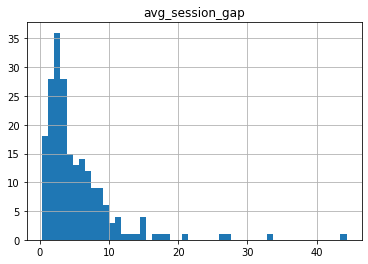

In [42]:
feats_pd.hist('avg_session_gap', bins=50);

In [81]:
# Replace missing values in avg_gap_session by 0

all_features = all_features.fillna(0, subset=['avg_session_gap'])

In [44]:
missing = all_features.select([F.count(F.when(
    (F.col(c) == '')  | F.col(c).isNull() | F.isnan(c), c)) \
    .alias(c) for c in all_features.columns])

In [45]:
missing.collect()

[Row(userId=0, gender=0, prop_activity=1, once_paid=0, once_free=0, avg_downgrad=0, avg_upgrad=0, avg_positive=0, avg_negative=0, NextSong=0, avg_sessions=0, avg_items_session=0, avg_session_gap=0)]

## Modeling

In [82]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, Normalizer, MinMaxScaler
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.classification import LogisticRegression, LinearSVC, DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import  MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [83]:
def extract_label(df):
    """ INPUTS: 
    - df: cleaned dataframe.
    - page: page value from which to extract label. """
    
    # Flag Churn. is_churning is 1 when the user was in the specified page
    flag_churn = F.udf(lambda p: int(p == "Cancellation Confirmation"), IntegerType())
    label_df = df.withColumn('is_churning', flag_churn(df.page))

    label_df = label_df.groupby('userId').agg(F.sum('is_churning').alias('label'))
    
    return label_df

In [84]:
def extract_features(df):
    """ 
    INPUT: cleaned dataframe. 
    OUTPUT: dataframe with Engineered Features.
    
    obs: daily average considers only active days, i.e. days in which the user has had 
         at least one event.
    
    These are the features per user:
    
    - gender: 1 if female, 0 if male
    - prop_activity: proportion of active days over total days in platform (from 
                     registration to last interaction)
    - once_paid and once_free - 1 if the user has been a paid or a free respectively
    - avg_downgrad and avg_upgrad - daily average of downgrades and upgrades respectively.
    - avg_positive and avg_negative - daily average of positive and negative interactions 
                                      respectively. 
    - avg_session: daily average of distinct sessions
    - avg_items_sessions: average items per session 
    - avg_session_gap: average gap between sessions
    
    """
    
    ### gender
    gender_df = df.select(['userId', 'gender']).dropDuplicates()
    gender_df = gender_df.withColumn("gender", F.when(df["gender"] == 'F', 1).otherwise(0))
    
    ### prop_activity 
    total_days = df.groupby('userId').agg(F.max('days_since_registration') \
                                          .alias('total_days'))
    active_days = df.groupby('userId').agg(F.countDistinct('date').alias('active_days'))
    
    avg_activity = total_days.join(active_days, on='userId').withColumn('prop_activity',
                                             F.col('active_days')/F.col('total_days'))\
                                             .drop(*['active_days', 'total_days'])
    
    ### once_paid and once_free
    # flag once_paid and once_free
    flag_paid = F.udf(lambda l: int(l == 'paid'), IntegerType())
    flag_free = F.udf(lambda l: int(l == 'free'), IntegerType())

    # is_paid is 1 whenever the user was in level == paid (same logic for is_free)
    once_level = df.withColumn('is_paid', flag_paid(df.level))
    once_level = once_level.withColumn('is_free', flag_free(df.level))

    once_level = once_level.groupby('userId').agg(F.max('is_paid').alias('once_paid'),
                                                  F.max('is_free').alias('once_free'))
        
    ### avg_downgrad
    user_window = Window.partitionBy('userId').orderBy(F.desc('ts')) \
                        .rangeBetween(Window.unboundedPreceding, 0)
    
    flag_downgrade = F.udf(lambda p: int(p == 'Submit Downgrade'), IntegerType())
    downgrad_df = df.withColumn('is_downgrading', flag_downgrade('page'))
    downgrad_df = downgrad_df.withColumn('down_phase', F.sum('is_downgrading') \
                                         .over(user_window))
    downgrad_df = downgrad_df.groupBy('userId').agg(F.max('down_phase') \
                                                    .alias('n_downgraded'))   
    
    active_days = df.groupby('userId').agg(F.countDistinct('date')\
                                        .alias('active_days'))
    avg_downgrad = downgrad_df.join(active_days, on='userId').withColumn(
                            'avg_downgrad', F.col('n_downgraded')/F.col('active_days'))\
                            .drop(*['n_downgraded', 'active_days'])
    
    ### avg_upgrad
    w = Window().partitionBy("userId").orderBy(F.asc("ts")) 
    upgrad_df = df.withColumn("first_level", F.when(F.row_number().over(w) == 1, 
                                                    F.col('level')))
    flag_upgrade = F.udf(lambda p, fl: int((p== 'Submit Upgrade') | (fl== 'paid')), 
                     IntegerType())
    upgrad_df = upgrad_df.withColumn('is_upgrading', 
                                     flag_upgrade(upgrad_df.page, upgrad_df.first_level))
    
    upgrad_df = upgrad_df.withColumn('up_phase', F.sum('is_upgrading').over(user_window))
    upgrad_df = upgrad_df.groupBy('userId').agg(F.max('up_phase').alias('n_upgraded'))
    
    avg_upgrad = upgrad_df.join(active_days, on='userId').withColumn(
                                'avg_upgrad', F.col('n_upgraded')/F.col('active_days'))\
                                .drop(*['n_upgraded', 'active_days'])
    
    ### avg_positive and avg_negative
    dfr = df.filter((df.page!= 'Cancel') & (df.page != 'Cancellation Confirmation'))
    page_counts = dfr.groupby(['userId', 'page']).agg((F.count('page')).alias('Count')) \
                     .groupby('userId').pivot('page').sum('Count').fillna(0)

    page_counts = page_counts.withColumn('positive_interact', 
                        F.col('Add Friend')+ F.col('Add to Playlist')+ F.col('Thumbs Up'))
    page_counts = page_counts.withColumn('negative_interact', 
                        F.col('Thumbs Down')+ F.col('Error')+ F.col('Roll Advert'))

    cols_to_drop = page_counts.columns[1:-2]
    page_counts_red = page_counts.drop(*cols_to_drop)
    
    joined = page_counts_red.join(active_days, on='userId')
    avg_types = joined.withColumn('avg_positive', 
                                  F.col('positive_interact')/F.col('active_days')) \
                                  .drop('positive_interact')
    avg_types = avg_types.withColumn('avg_negative', 
                                     F.col('negative_interact')/F.col('active_days')) \
                                     .drop(*['negative_interact', 'active_days'])
    
    ### avg_sessions
    avg_sessions = df.groupby('userId','date').agg(F.countDistinct('sessionId') \
                                                  .alias('sessions_per_day')) \
                     .groupBy('userId').agg(F.avg('sessions_per_day') \
                                       .alias('avg_sessions'))
    ### avg_items
    avg_items = df.groupby(['userId', 'sessionId']).agg(F.max('itemInSession') \
                                                        .alias('n_items_session')) \
                  .groupby('userId').agg(F.avg('n_items_session')
                                         .alias('avg_items_session'))
    
    ### avg_session_gap
    session_marks_df = df.groupby('userId','sessionId').agg(
                                                        F.min('ts').alias('begin_ts'),
                                                        F.max('ts').alias('end_ts'))
    w = Window.partitionBy('userID').orderBy('begin_ts')
    session_marks_df = session_marks_df.withColumn('last_end', F.lag(F.col('end_ts')) \
                                                   .over(w))

    session_marks_df = session_marks_df.withColumn('session_gap', 
                                                   (F.col('begin_ts') - F.col('last_end')))

    avg_session_gap = session_marks_df.groupby('userId').agg(
                                (F.avg('session_gap')/86400000).alias('avg_session_gap'))
    
    ### joining all together

    all_features = gender_df \
                        .join(avg_activity, on='userId')\
                        .join(once_level, on='userId')\
                        .join(avg_downgrad, on='userId')\
                        .join(avg_upgrad, on='userId')\
                        .join(avg_types, on='userId')\
                        .join(avg_sessions, on='userId')\
                        .join(avg_items, on='userId')\
                        .join(avg_session_gap, on='userId')

    
    # fill missing values
    all_features = all_features.fillna(0, subset=['avg_session_gap'])
    
    return all_features
    

In [85]:
def get_data_ready(path= "mini_sparkify_event_data.json"):
    """ INPUT: path with raw data.
        OUTPUT: data ready for modeling pipeline. """
    
    clean_df = load_and_clean(path)
    features = extract_features(clean_df)
    label = extract_label(clean_df)
    
    data = features.join(label, on='userId')
    data = data.drop('userId')
    
    return data

In [86]:
data = get_data_ready()

In [87]:
data.count(), len(data.columns)

(225, 12)

In [88]:
train, valid, test = data.randomSplit([0.75, 0.2, 0.15], seed=42)

We will try three models, using their defaults first: 
- Logistic Regression
- Random Forest
- Gradient Boosting

#### Comparing Models using defaults 

In [108]:
def build_pipeline(data, model):
        
    numCols = data.drop('label').columns
    assembler = VectorAssembler(inputCols= numCols, outputCol='NumFeatures', 
                                handleInvalid='skip')
    
    scaler = StandardScaler(inputCol="NumFeatures", outputCol="features", 
                                withMean=True, withStd=True)

    pipeline = Pipeline(stages=[assembler, scaler, model])
    
    return pipeline

In [109]:
def evaluate_pipeline(data, pipeline):
    """ Splits data, fits pipeline on train set and evaluates on valid set"""
    
    # Split
    train, valid, test = data.randomSplit([0.75, 0.2, 0.15], seed=42)
    
    # Train time
    t1 = time()
    fit_pipe = pipeline.fit(train)
    t2 = time()
    
    train_time = (t2-t1)/60
    
    # Results
    train_results = fit_pipe.transform(train)
    valid_results = fit_pipe.transform(valid)
        
    # Metrics
    train_f1 = MulticlassClassificationEvaluator(metricName='f1').evaluate(train_results)
    valid_f1 = MulticlassClassificationEvaluator(metricName='f1').evaluate(valid_results)
    
    metrics = [round(m, 3) for m in [train_f1, valid_f1, train_time]]  
    
    print('F1 score on TRAIN set:', metrics[0], '|', 'F1 score on VALID set:', metrics[1])
    
    return metrics

In [110]:
default_models = [LogisticRegression(), RandomForestClassifier(seed=42),
                 GBTClassifier(seed=42)]

In [114]:
results = {}

for model in default_models:
    model_name = str(model).split('_')[0]
    pipeline = build_pipeline(data, model)
    
    print('Evaluating model', model_name)
    results[model_name] = evaluate_pipeline(data, pipeline)

Evaluating model LogisticRegression
F1 score on TRAIN set: 0.806 | F1 score on VALID set: 0.632
Evaluating model RandomForestClassifier
F1 score on TRAIN set: 0.981 | F1 score on VALID set: 0.654
Evaluating model GBTClassifier
F1 score on TRAIN set: 1.0 | F1 score on VALID set: 0.647


In [115]:
results_pd = pd.DataFrame(results).rename(
    index={0: 'train_f1', 1:'valid_f1', 2:'train_time'})

In [116]:
results_pd

,LogisticRegression,RandomForestClassifier,GBTClassifier
train_f1,0.806,0.981,1.000
valid_f1,0.632,0.654,0.647
train_time,3.762,4.296,8.419


All models seem to be overfitting with default parameters, so we will perform a bit of tuning for all of them to recognize the one with the best metrics for our task

### Fine-tuning

We will use F1 as the metric to optimize for, since we have an imbalanced dataset and accuracy is a poor measure for that case.

In [77]:
def grid_search(data, model, paramGrid, kFolds=2):
    """ Performs crossvalidation with provided model and paramGrid. 
    
    Returns: 
    - F1 score for train set, F1 score for valid set and train time,
    - Best parameters found for the model
    - Fitted crossvalidation object for further exploration """
    
    # Split
    train, valid, test = data.randomSplit([0.75, 0.2, 0.15], seed=42)
    
    # pipeline
    pipeline = build_pipeline(data, model)
    
    # grid search
    crossval = CrossValidator(estimator= pipeline,
                          estimatorParamMaps= paramGrid,
                          evaluator= MulticlassClassificationEvaluator(),
                          numFolds= kFolds)
    
    t1 = time()
    fitCV = crossval.fit(train)
    t2 = time()
    
    train_time = round((t2-t1)/60, 2)
    
    train_f1 = MulticlassClassificationEvaluator().evaluate(fitCV.transform(train))
    valid_f1 = MulticlassClassificationEvaluator().evaluate(fitCV.transform(valid))
    
    best_params = fitCV.bestModel.stages[2].extractParamMap()
    
       
    return train_f1, valid_f1, train_time, best_params, fitCV

**Logistic Regression**
- defaults: maxIter= 100, regParam= 0.0
- best params: maxIter= 3, regParam= 0.02

In [78]:
model = LogisticRegression()

paramGrid = ParamGridBuilder()\
    .addGrid(model.maxIter, [3, 5, 10]) \
    .addGrid(model.regParam, [0.0, 0.01, 0.02]) \
    .build()

train_f1, valid_f1, train_time, best_params, fitCV = grid_search(data, model, paramGrid,
                                                                kFolds=3)

In [79]:
train_f1, valid_f1

(0.7549728752260398, 0.6318445431949988)

In [81]:
# maxIter= 3, regParam= 0.02
best_params

{Param(parent='LogisticRegression_e664af7201d6', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LogisticRegression_e664af7201d6', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0,
 Param(parent='LogisticRegression_e664af7201d6', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto',
 Param(parent='LogisticRegression_e664af7201d6', name='featuresCol', doc='features column name'): 'features',
 Param(parent='LogisticRegression_e664af7201d6', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LogisticRegression_e664af7201d6', name='labelCol', doc='label column name'): 'label',
 Param(parent='LogisticRegression_e664af7201d6', name='maxIter', doc='maximum number of iterations (>= 0)'): 

**Random Forest**
- dafaults: numTrees= 20, maxDepth= 5
- best params: numTrees= 70, maxDepth= 6

In [83]:
model = RandomForestClassifier(seed=42)

paramGrid = ParamGridBuilder()\
    .addGrid(model.numTrees, [50, 60, 65, 70, 75]) \
    .addGrid(model.maxDepth, [4, 5, 6, 7, 8]) \
    .build()

train_f1, valid_f1, train_time, best_params, fitCV = grid_search(data, model, paramGrid)
train_f1, valid_f1

(0.9871725897428089, 0.6709956709956709)

In [85]:
# numTrees= 70, maxDepth= 6
best_params

{Param(parent='RandomForestClassifier_3d2ee91c375a', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='RandomForestClassifier_3d2ee91c375a', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestClassifier_3d2ee91c375a', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto',
 Param(parent='RandomForestClassifier_3d2ee91c375a', name='featuresCol', doc='features column name'): 'features',
 Param(parent='RandomForestClassifier_3d2ee91c375a', 

**GBTClassifier**
- defaults: maxIter= 20, maxDepth= 5
- best params: maxIter= 6, maxDepth= 2

In [96]:
model = GBTClassifier(seed=42)

paramGrid = ParamGridBuilder()\
    .addGrid(model.maxIter, [4, 5, 6, 7, 8]) \
    .addGrid(model.maxDepth,[1, 2, 3]) \
    .build()

train_f1, valid_f1, train_time, best_params, fitCV = grid_search(data, model, paramGrid)

In [97]:
train_f1, valid_f1

(0.8716932672904054, 0.6709956709956709)

In [98]:
# maxIter= 6, maxDepth= 2 
best_params

{Param(parent='GBTClassifier_346a0c833970', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='GBTClassifier_346a0c833970', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='GBTClassifier_346a0c833970', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'all',
 Param(parent='GBTClassifier_346a0c833970', name='featuresCol', doc='features column name'): 'features',
 Param(parent='GBTClassifier_346a0c833970', name='labelCol', doc='label column name'): 'la

### Results

Let's compare the best versions of each model.

In [118]:
tuned_models = [LogisticRegression(maxIter= 3, regParam= 0.02), 
                RandomForestClassifier(seed=42, numTrees= 70, maxDepth= 6),
                GBTClassifier(seed=42, maxIter= 6, maxDepth= 2)]

In [119]:
tuned_results = {}

for model in tuned_models:
    model_name = str(model).split('_')[0]
    pipeline = build_pipeline(data, model)
    
    print('Evaluating model', model_name)
    tuned_results[model_name] = evaluate_pipeline(data, pipeline)

Evaluating model LogisticRegression
F1 score on TRAIN set: 0.755 | F1 score on VALID set: 0.632
Evaluating model RandomForestClassifier
F1 score on TRAIN set: 0.987 | F1 score on VALID set: 0.671
Evaluating model GBTClassifier
F1 score on TRAIN set: 0.872 | F1 score on VALID set: 0.671


In [120]:
tuned_results_pd = pd.DataFrame(tuned_results).rename(
    index={0: 'train_f1', 1:'valid_f1', 2:'train_time'})

In [121]:
tuned_results_pd

,LogisticRegression,RandomForestClassifier,GBTClassifier
train_f1,0.755,0.987,0.872
valid_f1,0.632,0.671,0.671
train_time,2.513,4.960,3.277


**Metrics on test set for Best Model**

In [122]:
train_and_valid = train.union(valid)
train_and_valid.count()

203

In [123]:
best_model = GBTClassifier(seed=42, maxIter= 6, maxDepth= 2)

pipeline = build_pipeline(data, best_model)
fit_pipe = pipeline.fit(train_and_valid)
test_results = fit_pipe.transform(test)

test_f1 = MulticlassClassificationEvaluator().evaluate(test_results)
test_f1

0.5898989898989899